# Cohort 240 downregulated AUCs ratios analysis

### Imports and environment setup

- Date of run: 2025-02-17
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [21]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [22]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [23]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [24]:
df_240 = pd.read_csv('../data/mmk_240_20240926.csv', sep=',', index_col=0, header=0)


In [25]:
# Harmonization of column names
df_240 = utils.normalize_column_names(df_240)

# To harmonize with other analyses, change _MIMARK to _MMK in column names
df_240.columns = [col.replace('_MIMARK', '') for col in df_240.columns]

In [26]:
df_240_dr = pd.read_csv('../data/mmk_240_TIMP_ADIPOQ_20250217.csv', sep='\t', index_col=0, header=0)


In [27]:
# Join the two dataframes by the index (named Sample)
df_240 = df_240.join(df_240_dr, how='inner')

In [28]:
df_240.head()

,Condition,TP_2022,AGRIN,KPYM,HSPB1,PERM,MMP9,TP_2024,TIMP-2,ADIPOQ
Sample,,,,,,,,,,
54,Benign,30.85,506.13,794.66,24701.90,360.97,36.51,37.64,65.112,547.727
309,Benign,9.21,108.91,168.89,5413.39,125.01,28.33,5.31,155.195,387.162
382,Benign,26.81,1445.13,2256.77,12927.05,558.55,207.37,22.60,0.402,733.204
433,Benign,20.08,129.36,254.48,3177.59,176.67,27.31,14.49,36.535,1930.970
484,Benign,28.27,677.80,1217.30,18193.34,389.55,139.50,17.80,95.949,834.905


In [33]:
df_240.value_counts('Condition')

Condition
Endometrial cancer    55
Benign                50
Name: count, dtype: int64

In [30]:
# Ensure numeric columns are treated as such
cols_to_num = ["TP_2022","AGRIN","KPYM","HSPB1","PERM","MMP9","TP_2024","TIMP-2","ADIPOQ"]
df_240 = utils.cols_as_numbers(df_240, cols_to_num)

In [31]:
# Columns to be considered as biomarkers
BIOMARKERS_240 = ['MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM']


### Create new columns for biomarker ratios

In [32]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_240:
    for biomarker2 in BIOMARKERS_240:
        if biomarker1 != biomarker2:
            df_240[f'{biomarker1}_{biomarker2}'] = df_240[biomarker1].div(df_240[biomarker2], axis=0)
            # Make infinite values NaN
            df_240[f'{biomarker1}_{biomarker2}'] = df_240[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [34]:
# Ensure categorical columns are treated as such
df_240 = utils.cols_as_category(df_240, {'Condition':{'Benign': 0, 'Endometrial cancer': 1}})

In [40]:
# Rename 'Condition' column to 'Pathology'
df_240.rename(columns={'Condition': 'Pathology'}, inplace=True)

# Execution parameters

In [37]:
PLOT_ROCS = False
RESULTS_PATH = '../data/results/240_dr_ratios'

# The biomarkers now include the ratios
BIOMARKERS_240 = [f"{biomarker1}_{biomarker2}" for biomarker1 in BIOMARKERS_240 for biomarker2 in BIOMARKERS_240 if biomarker1 != biomarker2]

NORMALIZING_COL_240 = ''
VOLUME_COL = ''

Since we are using ratios, we are interested only in the $direct$ method.

In [38]:
METHODS = ['direct']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [45]:
MAX_BIOMARKER_COUNT = 3

models_240 = utils.compute_all_models_and_save(
                            df=df_240,
                            biomarkers=BIOMARKERS_240,
                            normalizing_col=NORMALIZING_COL_240, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=False,
                            auc_threshold=0.0,
                            )

Let's do the same for single biomarkers.

In [47]:
MAX_BIOMARKER_COUNT = 1

models_240_1 = utils.compute_all_models_and_save(
                            df=df_240,
                            biomarkers=BIOMARKERS_240,
                            normalizing_col=NORMALIZING_COL_240, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.0,
                            compute_auc_ci=True
                            )

# Results

Given the number of models computed for different amounts of ratios, AUC results are not shown here but saved in the correspondent results folder.

## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [50]:
aucs = []
auc_cis = []
models = []

for model in models_240_1['direct'][(list(models_240_1['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_240_1['direct'][(list(models_240_1['direct'].keys())[0])][model]['auc']
    if model_auc > 0.7 or model_auc < 0.3:
        model_auc_ci = models_240_1['direct'][(list(models_240_1['direct'].keys())[0])][model]['auc_ci']
        aucs.append(float(model_auc))
        auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
        models.append(model_name)

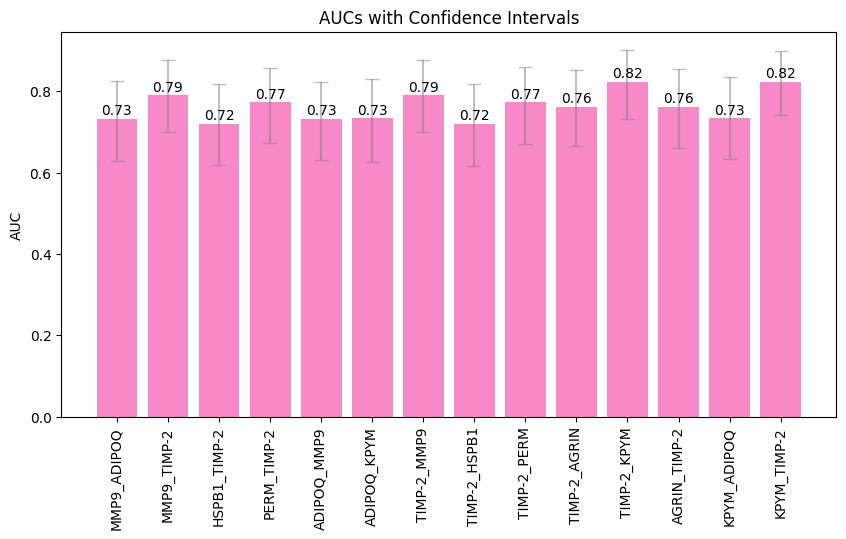

In [51]:
custom_palette = {0: "#f789c8", 1: "#f41c11"}  # Use MMK colors

auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(
    models,
    aucs,
    yerr=yerr,
    capsize=5,
    align='center',
    color=custom_palette[0],
    error_kw={'elinewidth': 1.5, 'alpha': 0.5, 'ecolor': 'gray'}  # Customize error bars
)

# Add text with the value of the bar in the top center of the error bars
for i in range(len(models)):
    plt.text(i, aucs[i] + 0.01, f'{aucs[i]:.2f}', ha='center')


plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()